# Sign Game Server

In [71]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import string
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
import timeit

from sign_game.ml.landmarks import Landmarks
import cv2

## Dataset Preprocessing

In [2]:
# Dataset
df_train = pd.read_csv('/Users/calebgarfinkel/Documents/Study/Le Wagon/Project/data/train.csv')
df_test = pd.read_csv('/Users/calebgarfinkel/Documents/Study/Le Wagon/Project/data/test.csv')

In [3]:
df_test.columns

Index(['Unnamed: 0', 'WRIST_X', 'WRIST_Y', 'WRIST_Z', 'THUMB_CMC_X',
       'THUMB_CMC_Y', 'THUMB_CMC_Z', 'THUMB_MCP_X', 'THUMB_MCP_Y',
       'THUMB_MCP_Z', 'THUMB_IP_X', 'THUMB_IP_Y', 'THUMB_IP_Z', 'THUMB_TIP_X',
       'THUMB_TIP_Y', 'THUMB_TIP_Z', 'INDEX_FINGER_MCP_X',
       'INDEX_FINGER_MCP_Y', 'INDEX_FINGER_MCP_Z', 'INDEX_FINGER_PIP_X',
       'INDEX_FINGER_PIP_Y', 'INDEX_FINGER_PIP_Z', 'INDEX_FINGER_DIP_X',
       'INDEX_FINGER_DIP_Y', 'INDEX_FINGER_DIP_Z', 'INDEX_FINGER_TIP_X',
       'INDEX_FINGER_TIP_Y', 'INDEX_FINGER_TIP_Z', 'MIDDLE_FINGER_MCP_X',
       'MIDDLE_FINGER_MCP_Y', 'MIDDLE_FINGER_MCP_Z', 'MIDDLE_FINGER_PIP_X',
       'MIDDLE_FINGER_PIP_Y', 'MIDDLE_FINGER_PIP_Z', 'MIDDLE_FINGER_DIP_X',
       'MIDDLE_FINGER_DIP_Y', 'MIDDLE_FINGER_DIP_Z', 'MIDDLE_FINGER_TIP_X',
       'MIDDLE_FINGER_TIP_Y', 'MIDDLE_FINGER_TIP_Z', 'RING_FINGER_MCP_X',
       'RING_FINGER_MCP_Y', 'RING_FINGER_MCP_Z', 'RING_FINGER_PIP_X',
       'RING_FINGER_PIP_Y', 'RING_FINGER_PIP_Z', 'RING_FINGER

In [4]:
# Drop unwanted columns in train/test sets
df_test = df_test.drop(columns=df_test.columns[[0, -1]], axis=1)
df_train = df_train.drop(columns=df_train.columns[[0, -1]], axis=1)

In [66]:
df_t.shape

(172629, 64)

In [5]:
# Drop NA values, reset index
df_train = df_train.dropna().reset_index(drop=True)
df_test = df_test.dropna().reset_index(drop=True)

In [6]:
X_train, y_train = df_train.drop("TARGET", axis=1), df_train[['TARGET']]
X_test, y_test = df_test.drop("TARGET", axis=1), df_test[['TARGET']]

In [7]:
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size = 0.5, random_state = 42)

In [8]:
y_test.shape

(21650, 1)

In [9]:
# Encode y to numeric
oe = OrdinalEncoder()
oe.fit(y_train.values.reshape(-1,1))
y_train_enc = oe.transform(y_train.values.reshape(-1,1))
y_val_enc = oe.transform(y_val.values.reshape(-1,1))
y_test_enc = oe.transform(y_test.values.reshape(-1,1))

## Run below to load model

In [ ]:
model = xgb.Booster()
model.load_model('model_xgboost.h5')

## Run Below to Retrain Model

In [12]:
params = {
    "max_depth": 10,
    "learning_rate": 0.01,
    "gamma" : 1,
    "objective": "multi:softprob", 
    "tree_method": "hist", 
    "num_class": 26
}


dtrain_clf = xgb.DMatrix(X_train, label=y_train_enc)
dval_clf = xgb.DMatrix(X_val, label=y_val_enc)

evallist = [(dval_clf, 'eval'), (dtrain_clf, 'train')]

num_rounds = 1000

model = xgb.train(params = params, 
                  dtrain = dtrain_clf, 
                  num_boost_round = num_rounds, 
                  evals = evallist,
                  verbose_eval = 20,
                  early_stopping_rounds = 50
                 )


[0]	eval-mlogloss:3.15856	train-mlogloss:3.15520
[20]	eval-mlogloss:2.14679	train-mlogloss:2.10184
[40]	eval-mlogloss:1.67679	train-mlogloss:1.61056
[60]	eval-mlogloss:1.37432	train-mlogloss:1.29364
[80]	eval-mlogloss:1.15502	train-mlogloss:1.06397
[100]	eval-mlogloss:0.98615	train-mlogloss:0.88754
[120]	eval-mlogloss:0.85231	train-mlogloss:0.74842
[140]	eval-mlogloss:0.74432	train-mlogloss:0.63586
[160]	eval-mlogloss:0.65574	train-mlogloss:0.54349
[180]	eval-mlogloss:0.58270	train-mlogloss:0.46755
[200]	eval-mlogloss:0.52169	train-mlogloss:0.40410
[220]	eval-mlogloss:0.47034	train-mlogloss:0.35090
[240]	eval-mlogloss:0.42726	train-mlogloss:0.30631
[260]	eval-mlogloss:0.39030	train-mlogloss:0.26833
[280]	eval-mlogloss:0.35893	train-mlogloss:0.23614
[300]	eval-mlogloss:0.33188	train-mlogloss:0.20883
[320]	eval-mlogloss:0.30864	train-mlogloss:0.18539
[340]	eval-mlogloss:0.28853	train-mlogloss:0.16529
[360]	eval-mlogloss:0.27136	train-mlogloss:0.14838
[380]	eval-mlogloss:0.25645	train-mlo

## Evaluate Model

In [77]:
dtest = xgb.DMatrix(X_test)
y_pred = np.argmax(model.predict(dtest), axis=1)

accuracy = accuracy_score(y_test_enc, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.22%


In [78]:
from sign_game.ml.evaluate import evaluate_model

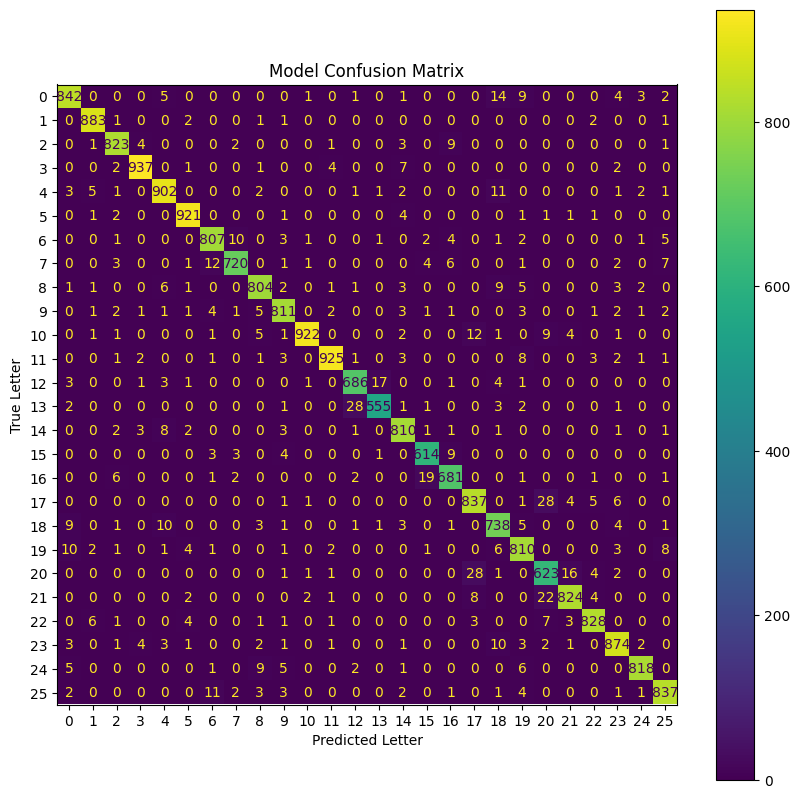

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       882
         1.0       0.98      0.99      0.99       891
         2.0       0.97      0.98      0.97       844
         3.0       0.98      0.98      0.98       954
         4.0       0.96      0.97      0.96       932
         5.0       0.98      0.99      0.98       933
         6.0       0.96      0.96      0.96       838
         7.0       0.97      0.95      0.96       758
         8.0       0.96      0.96      0.96       839
         9.0       0.96      0.96      0.96       843
        10.0       0.99      0.96      0.98       960
        11.0       0.99      0.97      0.98       952
        12.0       0.95      0.96      0.95       718
        13.0       0.96      0.93      0.95       594
        14.0       0.96      0.97      0.96       834
        15.0       0.95      0.97      0.96       634
        16.0       0.95      0.95      0.95       714
        17.0       0.94    

In [79]:
evaluate_model(y_test_enc, y_pred)

## Run to save model

In [75]:
model.save_model("model_xgboost.h5")

# Testing

In [15]:
landmarks = Landmarks()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [16]:
image=cv2.imread('../sample_sets/img/Letter.png')

In [17]:
cv2_img_w_landmarks, landmark_object = landmarks.image_to_landmark(image, draw_landmarks=True)

In [18]:
img_test = pd.DataFrame.from_dict([landmark_object])

In [19]:
img_test

,WRIST_x,WRIST_y,WRIST_z,THUMB_CMC_x,THUMB_CMC_y,THUMB_CMC_z,THUMB_MCP_x,THUMB_MCP_y,THUMB_MCP_z,THUMB_IP_x,...,PINKY_MCP_z,PINKY_PIP_x,PINKY_PIP_y,PINKY_PIP_z,PINKY_DIP_x,PINKY_DIP_y,PINKY_DIP_z,PINKY_TIP_x,PINKY_TIP_y,PINKY_TIP_z
0,0.261234,0.642789,-4.421173e-07,0.313893,0.610385,-0.014049,0.35688,0.54315,-0.020047,0.383495,...,-0.025077,0.251333,0.424395,-0.039875,0.255736,0.477642,-0.028354,0.254637,0.510424,-0.014955


In [20]:
img_test = img_test.rename(columns=lambda x: x.replace('_x', '_X').replace('_y', '_Y').replace('_z', '_Z'))

In [23]:
dtest = xgb.DMatrix(img_test)
y_pred = np.argmax(model.predict(dtest), axis=1)

In [24]:
y_pred

array([18])

## Test 2

In [57]:
image = cv2.imread('../sample_sets/img/letter_r.jpg')
cv2_img_w_landmarks, landmark_object = landmarks.image_to_landmark(image, draw_landmarks=True)
img_test = pd.DataFrame.from_dict([landmark_object])
img_test = img_test.rename(columns=lambda x: x.replace('_x', '_X').replace('_y', '_Y').replace('_z', '_Z'))

dtest = xgb.DMatrix(img_test)
y_pred = np.argmax(model.predict(dtest), axis=1)
y_pred

array([20])

In [84]:
start_time = timeit.default_timer()

image = cv2.imread('../sample_sets/img/letter_u.jpg')
cv2_img_w_landmarks, landmark_object = landmarks.image_to_landmark(image, draw_landmarks=True)
img_test = pd.DataFrame.from_dict([landmark_object])
img_test = img_test.rename(columns=lambda x: x.replace('_x', '_X').replace('_y', '_Y').replace('_z', '_Z'))

dtest = xgb.DMatrix(img_test)
y_pred = np.argmax(model.predict(dtest), axis=1)

elapsed = timeit.default_timer() - start_time
print(f"Time taken to run this cell: {elapsed:.6f} seconds")
print(y_pred)


Time taken to run this cell: 0.052486 seconds
[20]


In [83]:
# let's add timeit to calculate how long it takes to run this cell?

start_time = timeit.default_timer()

image = cv2.imread('../sample_sets/img/letter_i.png')
cv2_img_w_landmarks, landmark_object = landmarks.image_to_landmark(image, draw_landmarks=True)
img_test = pd.DataFrame.from_dict([landmark_object])
img_test = img_test.rename(columns=lambda x: x.replace('_x', '_X').replace('_y', '_Y').replace('_z', '_Z'))

dtest = xgb.DMatrix(img_test)
y_pred = np.argmax(model.predict(dtest), axis=1)

elapsed = timeit.default_timer() - start_time
print(f"Time taken to run this cell: {elapsed:.6f} seconds")
print(y_pred)


Time taken to run this cell: 0.148054 seconds
[8]
